## This file works out the average z-score inside a gradient percentile area

This should reproduce [this analysis](https://github.com/NeuroanatomyAndConnectivity/gradient_analysis/blob/master/05_metaanalysis_neurosynth.ipynb)

_written by Jan Freyberg for the Brainhack 2017 Project_

In [29]:
% matplotlib inline 

from __future__ import print_function

import nibabel as nib
from nilearn.image import resample_img

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import os.path

# The following are a progress bar, these are not strictly necessary:
from ipywidgets import FloatProgress
from IPython.display import display

Define the variables for this analysis. 
1. how many percentiles the data is divided into
2. where the Z-Maps (from neurosynth) lie
3. where the binned gradient maps lie
4. where a mask of the brain lies (not used at the moment).

In [2]:
percentiles = range(10)

# unthresholded z-maps from neurosynth:
zmaps = [os.path.join(os.getcwd(), 'ROIs_Mask', fname) for fname in os.listdir(os.path.join(os.getcwd(), 'ROIs_Mask'))
         if 'z.nii.gz' in fname]

# individual, binned gradient maps, in a list of lists:
gradmaps = [[os.path.join(os.getcwd(), 'data', 'Outputs', 'Bins', str(percentile), fname)
             for fname in os.listdir(os.path.join(os.getcwd(), 'data', 'Outputs', 'Bins', str(percentile)))]
            for percentile in percentiles]

# a brain mask file:
brainmask = os.path.join(os.getcwd(), 'ROIs_Mask', 'rbgmask.nii')

Next define a function to take the average of an image inside a mask and return it:

In [3]:
def zinsidemask(zmap, mask):
    # check if mapping is the same, otherwise transform:
    if zmap.shape != mask.shape:
        zmap = resample_img(zmap, target_affine=mask.affine, target_shape=mask.shape)
    zaverage = zmap.dataobj[np.not_equal(mask.dataobj, 0)].mean()
    return zaverage

This next cell will step through each combination of gradient, subject and network file to calculate the average z-score inside the mask defined by the gradient percentile. This will take a long time to run!

__NB If you are running this again / on your own machine, it's probably 100x faster to move the `resample_img` step outside of the function so you only resample each zmap once...__

In [ ]:
zaverages = np.zeros([len(zmaps), len(gradmaps), len(gradmaps[0])])

progbar = FloatProgress(min=0, max=zaverages.size)
display(progbar)
# load first gradmap just for resampling
gradmap = nib.load(gradmaps[0][0])
for i1, zmapfile in enumerate(zmaps):
    zmap = nib.load(zmapfile)
    zmap = resample_img(zmap, target_affine=gradmap.affine)
    for i2, percentile in enumerate(percentiles):
        for i3, gradmapfile in enumerate(gradmaps[percentile]):
            gradmap = nib.load(gradmapfile)
            zaverages[i1, i2, i3] = zinsidemask(zmap, gradmap)
            progbar.value += 1


To save time next time, we'll save the result of this to file:

In [8]:
np.save(os.path.join(os.getcwd(), 'data', 'average-z-scores'), zaverages)

In [36]:
zaverages = np.load(os.path.join(os.getcwd(), 'data', 'average-z-scores.npy'))
zaverages.shape

(19, 10, 160)

Extract a list of which group contains which participants.

In [74]:
df_phen = pd.read_csv('data' + os.sep + 'SelectedSubjects.csv')
diagnosis = df_phen.loc[:, 'DX_GROUP']
fileids = df_phen.loc[:, 'FILE_ID']

groupvec = np.zeros(len(gradmaps[0]))
for filenum, filename in enumerate(gradmaps[0]):
    fileid = os.path.split(filename)[-1][5:-22]
    groupvec[filenum] = (diagnosis[fileids.str.contains(fileid)])

print(groupvec.shape)

(160,)


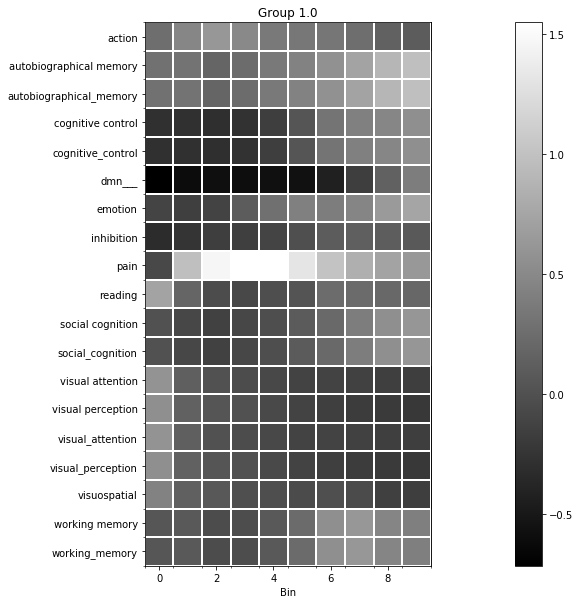

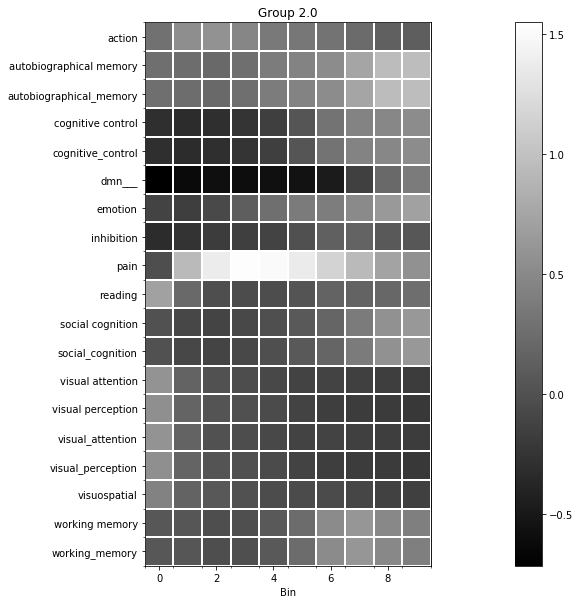

In [92]:
for group in np.unique(groupvec):
    plt.figure(figsize=(30, 10))
    plt.imshow(zaverages[:, :, groupvec==group].mean(axis=2),
               cmap='gray', interpolation='nearest',
               vmin=zaverages[:, :, :].mean(axis=2).min(),
               vmax=zaverages[:, :, :].mean(axis=2).max())
    
    ax = plt.gca()
    plt.xlabel('Bin')
    plt.colorbar(cmap='gray')
    plt.title('Group ' + str(group))

    ylabels = [os.path.split(fname)[-1][0:-14] for fname in zmaps]

    ax.set_yticks(np.arange(0, len(zmaps), 1))
    ax.set_yticklabels(ylabels)

    ax.set_yticks(np.arange(-0.5, len(zmaps), 1), minor=True)
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.grid(which='minor', color='w', linewidth=2)

pass